# Get discount factor for JPY
- input: MoneyMarket (short term interest rate), Swap rate.
- output: discount factors for each tenor listed by MoneMarket and Swap rate.

## Pricing
### Swap pricing formula
The value of the exchange between a floot and a fixed side is given by
$$
V = \sum_{i = 1}^{N}  L(t_{i-1}, t_{i}) \times DF(t_{i}) \times \delta_{i} - \sum_{i = 1}^{N} SwapRate \times DF(t_{i})\times \delta_{i},
$$
where $L(t_{i-1}, t_{i})$ is the floot interest rate between $t_{i-1}$ and $t_{i}$, $DF(t_{i})$ is a discount factor, $\delta_{i}$ is a day-count-fraction and $SwapRate$ is a Swap rate which means a par rate for a swap trade.

### Bootstrap method for getting discount factors
Discount factors as of today can be estimated from a par swap trade which corresponds to $V = 0$ under swap pricing formula. 
For example, let us consider a swap trade with maturity of 1.5 year. The discount factor for 1.5 year $DF(t_{1.5Y})$ is calculated by solveing the following equation:
$$
\sum_{i = 1}^{3}  L(t_{i-1}, t_{i}) \times DF(t_{i}) \times \delta = \sum_{i = 1}^{3} SwapRate(1.5Y) \times DF(t_{i})\times \delta
$$

where a quoted swap rate is used for $SwapRate(1.5Y)$, the day-count-fraction $\delta$ is asuumed 6 month and the floot side interest rate is assumed that a following model expressed as
$$
L(t_{i-1}, t_{i}) = \frac{1}{\delta} \Big( \frac{ DF(t_{i-1}) }{ DF(t_{i}) } - 1 \Big).
$$
The above equation can be solved by using $DF(t_{0.5Y})$, $DF(t_{1.0Y})$ and the floot interest rate which is defined as above equation. As a result, the discount factor $DF(t_{1.5Y})$  is given by
$$
DF(t_{1.5Y}) = \frac{1}{(1 + \delta \times SwapRate(1.5Y))} \Big( DF(t_{0}) - SwapRate(1.5Y) \times \delta \times \big(DF(t_{0.5Y}) + DF(t_{1.0Y}) \big) \Big),
$$

where $DF(t_{0.5Y})$ and $DF(t_{1.0Y})$ is calculated by using a quoted LIBOR (the rate of Money Market). The short rate of Money Market means spot rate, where the cashflows is expressed as only two terms. For example, $DF(t_{0.5Y})$ is given by
$$
DF(t_{0.5Y}) = \frac{1}{( 1 + \delta \times L(0.0Y, 0.5Y))},
$$

where $L(0.0Y, 0.5Y)$ is the LIBOR rate between today and 6 month later.
Discount factors after $t_{1.5Y}$ can be calculated by the same way as the derivation of $DF(t_{1.5Y})$.
This method of getting discount factors gradually is called Bootstrap method.

[](
Continuously, let us consider a T/N swap trade. When $V = 0$ under the swap pricing formula, it is written by 
$$
FixedRate(T/N)\ ( DF(t_{O/N}) \times \delta_{1} + DF(t_{T/N}) \times \delta_{2} ) \\
 = ( DF(t_{O/N}) - DF(t_{0}) ) \delta_{1} + (DF(t_{T/N}) - DF(t_{O/N})) \delta_{2}, 
$$  
\
where $\delta_2$ is a day-count-fraction between $t_{O/N}$ and $t_{T/N}$ and a quoted Tomorrow-Next Rate is used for $FixedRate(T/N)$. 
This equation can be solved for $DF(t_{T/N})$ by using $DF(t_{O/N})$ which is derived from the above equation. 
In this way, discount factors at each tenor is calculated. This method for getiing discount factors is called as Bootstrap method. 
The expression of $DF(t_{T/N})$ is given by 
$$
DF(t_{T/N}) = \frac{ FixedRate(T/N)\times DF(t_{O/N}) + DF(t_0) }{ 1 - FixedRate(T/N) } 
$$
'')

In [1]:
''' import matplotlib.pyplot as plt
import numpy as np
import datetime

class getDF_moneymarket:
   def __init__(self, libor_rate, start_day, end_day):
        self.libor_rate = libor_rate
        self.start_day = start_day
        self.end_day = end_day
        self.datetime_obj_start = datetime.datetime.strptime(start_day, '%Y/%m/%d')
        self.datetime_obj_end = datetime.datetime.strptime(end_day, '%Y/%m/%d')
        self.daycount = (self.datetime_obj_end - self.datetime_obj_start).days / 360
        self.discount_factor = 0
        
    def __init__(self, today, array_ccy):
            self._start_day = today

    def getDF(self, seq_moneymarket):
'''        

IndentationError: expected an indented block (<ipython-input-1-180ce8381581>, line 14)

In [175]:
'''DF = getDF_moneymarket(0.2, '2017/12/18', '2019/12/30')
print(DF.discount_factor)
print(DF.getDF())
print(DF.discount_factor)
'''

"DF = getDF_moneymarket(0.2, '2017/12/18', '2019/12/30')\nprint(DF.discount_factor)\nprint(DF.getDF())\nprint(DF.discount_factor)\n"

In [174]:
'''DF1 = getDF_moneymarket(0.3, '2017/12/18', '2018/3/20')
DF1.getDF()
'''

"DF1 = getDF_moneymarket(0.3, '2017/12/18', '2018/3/20')\nDF1.getDF()\n"

# 1/20
- money marketのDFのリストの形式を変更
    - [tenor, DF]　から [tenor, start, end, labor_rate, DF]の形式に変更

In [7]:
%matplotlib inline
import numpy as np
import csv
import time
import datetime
import matplotlib.pyplot as plt

with open('sample_moneymarket.csv', 'r') as csvfile:
    reader_obj = csv.reader(csvfile)
    # rewritten header_obj by using next method(???)
    header_obj = next(reader_obj)
    mm_list = []
    for row in reader_obj:
        mm_list.append(row)

def get_DF_MM(money_market_list):
    list_len = len(money_market_list)
#    discount_factor = np.zeros(list_len*2).reshape(list_len, 2)
    discount_factor_list = [["", "", "", 0.0,0.0] for i in range(list_len)]
#    discount_factor = [["", 0.0] for i in range(list_len)]
    day_count_fraction = np.zeros(list_len)
    # substitution the kinf of trade
    for i in range(0, list_len):
        discount_factor_list[i][0] = money_market_list[i][0]
        discount_factor_list[i][1] = money_market_list[i][1]
        discount_factor_list[i][2] = money_market_list[i][2]
        discount_factor_list[i][3] = float(money_market_list[i][3])
    # calc daycount-fraction
    convention = 360.0
    for i in range(0, len(day_count_fraction)):
        day_count_fraction[i] = calc_daycount(money_market_list[i][1], money_market_list[i][2], convention)
    # calculate DF of O/N
    discount_factor_list[0][4] = 1.0 / (1.0 + day_count_fraction[0] * float(discount_factor_list[0][3]))
    # calculate DF of  T/N
    discount_factor_list[1][4] = discount_factor_list[0][4] /(1.0 + day_count_fraction[1]*float(discount_factor_list[1][3]))
    # calculate DF after 1W
    for i in range(2, list_len):
        discount_factor_list[i][4] = discount_factor_list[1][4] / (1.0 + day_count_fraction[i] * float(discount_factor_list[i][3]))
    return discount_factor_list
                                   
def calc_daycount(start_day, end_day, convention):
    datetime_obj_start = datetime.datetime.strptime(start_day, '%Y/%m/%d')
    datetime_obj_end = datetime.datetime.strptime(end_day, '%Y/%m/%d')
    daycount = (datetime_obj_end - datetime_obj_start).days / convention
    return daycount

def draw_DF(seq_discount_factor):
        list_len = len(seq_discount_factor)
        seq_DF = np.zeros(list_len)
        for i in range(0, list_len):
            seq_DF[i] = seq_discount_factor[i][1]
        plt.plot(seq_DF)
        plt.ylim([0,1.0])


list_discountfactor = get_DF_MM(mm_list)
list_discountfactor
# draw_DF(list_discountfactor)

[['O/N', '2017/12/23', '2017/12/24', 0.014348, 0.99996014603284633],
 ['T/N', '2017/12/24', '2017/12/25', 0.014348, 0.99992029365403134],
 ['1W', '2017/12/25', '2018/1/1', 0.014876, 0.99963114479189386],
 ['2W', '2017/12/25', '2018/1/8', 0.015, 0.99933734686835807],
 ['1M', '2017/12/25', '2018/1/24', 0.01563, 0.99861959163592562],
 ['2M', '2017/12/25', '2018/2/23', 0.01616, 0.9972344089791807],
 ['3M', '2017/12/25', '2018/3/25', 0.01685, 0.99572579872689437],
 ['6M', '2017/12/25', '2018/6/23', 0.01833, 0.99083925191027356],
 ['1Y', '2017/12/25', '2018/12/20', 0.021, 0.97935386254067724]]

In [8]:
with open('sample_moneymarket.csv', 'r') as csvfile:
    reader_obj = csv.reader(csvfile)
    # rewritten header_obj by using next method(???)
    header_obj = next(reader_obj)
    mm_list = []
    for row in reader_obj:
        mm_list.append(row)

mm_list

[['O/N', '2017/12/23', '2017/12/24', '0.014348'],
 ['T/N', '2017/12/24', '2017/12/25', '0.014348'],
 ['1W', '2017/12/25', '2018/1/1', '0.014876'],
 ['2W', '2017/12/25', '2018/1/8', '0.015'],
 ['1M', '2017/12/25', '2018/1/24', '0.01563'],
 ['2M', '2017/12/25', '2018/2/23', '0.01616'],
 ['3M', '2017/12/25', '2018/3/25', '0.01685'],
 ['6M', '2017/12/25', '2018/6/23', '0.01833'],
 ['1Y', '2017/12/25', '2018/12/20', '0.021']]

# 1/15
- データの加工
    - 小数点表記 ("{:.1f}".format())
    - 文字列の結合　（+でできる）
- 空のリスト作成
    - 内包表記 -> [5 for i in range(10)] -> 5が１０個のリスト

In [9]:
with open('sample_swaprate.csv', 'r') as csvfile:
    reader_obj = csv.reader(csvfile)
    # rewritten header_obj by using next method(???)
    header_obj = next(reader_obj)
    swap_rate_list = []
    for row in reader_obj:
        swap_rate_list.append(row)
    temp_num = [[] for i in range(len(swap_rate_list))] # comprehension expression for making null list.
    ### proceccing the expression for the type of 1Y to 1.0Y.
    for i in range(len(swap_rate_list)):
        if (len(swap_rate_list[i][0]) == 2):
            temp_num[i] = "{:.1f}".format(int(swap_rate_list[i][0][0])) + swap_rate_list[i][0][1]
            swap_rate_list[i][0] = temp_num[i]
        elif (len(swap_rate_list[i][0]) == 3):
            temp_num[i] = "{:.1f}".format(int(swap_rate_list[i][0][0:2])) + swap_rate_list[i][0][2]
            swap_rate_list[i][0] = temp_num[i]
        else:
            break

swap_rate_list

[['1.0Y', '2017/12/25', '2018/12/25', '0.01904'],
 ['2.0Y', '2017/12/25', '2019/12/25', '0.02086'],
 ['3.0Y', '2017/12/25', '2020/12/24', '0.02187'],
 ['4.0Y', '2017/12/25', '2021/12/24', '0.02248'],
 ['5.0Y', '2017/12/25', '2022/12/24', '0.02295'],
 ['6.0Y', '2017/12/25', '2023/12/24', '0.02337'],
 ['7.0Y', '2017/12/25', '2024/12/23', '0.02376'],
 ['8.0Y', '2017/12/25', '2025/12/23', '0.02411'],
 ['9.0Y', '2017/12/25', '2026/12/23', '0.02444'],
 ['10.0Y', '2017/12/25', '2027/12/23', '0.02475'],
 ['15.0Y', '2017/12/25', '2032/12/21', '0.02582'],
 ['20.0Y', '2017/12/25', '2037/12/20', '0.02632'],
 ['30.0Y', '2017/12/25', '2047/12/18', '0.02646']]

In [10]:
calc_daycount(mm_list[0][1], mm_list[0][2], 360)
calc_daycount(mm_list[5][1], mm_list[5][2], 360)

0.16666666666666666

# 1/15
- エクセルのVlookup風の作業
    - 半年置きのテナーで，空のswap rateのリストを作成
    - 外部データとして存在する，加工済みの（1Y->1.0Y）データとマッチする行はそのまま置き換え
    - マッチしない行は据え置きでデフォルトの0を代入したままのリストを作成
    
# 1/16
- get_end_day()関数の作成
    - 祝日，　土日勘案はせず．(ってかどうやるの？)

In [136]:
def get_end_day(maturity, start_day):
    datetime_obj_start = datetime.datetime.strptime(start_day, '%Y/%m/%d')
    effective_days = float(maturity[0:len(maturity)-1])*365
    end_day = datetime_obj_start + datetime.timedelta(days=effective_days)
    return end_day.strftime('%Y/%m/%d')

from scipy.interpolate import interp1d
def interpolation_swap_rate(swap_rate_list):
    xaxis_date = []
    yaxis_swap_rate = []
    for i in range(len(swap_rate_list)):
        xaxis_date.append(float(swap_rate_list[i][0][0:len(swap_rate_list[i][0])-1]))
        yaxis_swap_rate.append(float(swap_rate_list[i][3]))
    f_interpolated_swap_rate = interp1d(xaxis_date, yaxis_swap_rate)
    return f_interpolated_swap_rate

def get_interpolated_swap_rate_list(swap_rate_list, tenor):
    max_maturity = float(swap_rate_list[-1][0][0:len(swap_rate_list[-1][0])-1])
    seq_len_of_swap_rate = int(max_maturity/tenor - 1)
    array_swap_rate = [["", 0, 0, 0] for i in range(seq_len_of_swap_rate )]
    for i in range(2,seq_len_of_swap_rate +2):
        array_swap_rate[i-2][0] = "{}Y".format(i*tenor)
    func_interpolated_swap_rate = interpolation_swap_rate(swap_rate_list)
    ## for sentence is nested...
    ## I wanna reviese code, but I have not an idea. Please tell me better coding if you have.
    for i in range(len(array_swap_rate)):
        array_swap_rate[i][1] = swap_rate_list[0][1]
        array_swap_rate[i][2] = get_end_day(array_swap_rate[i][0], array_swap_rate[i][1])
        interpolated_date = float(array_swap_rate[i][0][0:len(array_swap_rate[i][0])-1])
        array_swap_rate[i][3] = float(func_interpolated_swap_rate(interpolated_date))
        for j in range(len(swap_rate_list)):
            if (array_swap_rate[i][0] in swap_rate_list[j][0]):
                array_swap_rate[i] = swap_rate_list[j]
                break
                
    return array_swap_rate

def get_DF(money_market_list, swap_rate_list, tenor):
    interpolated_swap_rate_list_temp = get_interpolated_swap_rate_list(swap_rate_list, tenor)
    interpolated_swap_rate_list = interpolated_swap_rate_list_temp[1:len(interpolated_swap_rate_list_temp)]
    interpolated_DF_swap_rate_list = [["", "", "", 0.0, 0.0] for i in range(len(interpolated_swap_rate_list))]
    ## interpolated_swa_rate_list[i].append(0)では，swap_rate_listが上書きされていく... append使って書くにはどうする？
    for i in range(len(interpolated_swap_rate_list)):
        interpolated_DF_swap_rate_list[i][0] = interpolated_swap_rate_list[i][0]
        interpolated_DF_swap_rate_list[i][1] = interpolated_swap_rate_list[i][1]
        interpolated_DF_swap_rate_list[i][2] = interpolated_swap_rate_list[i][2]
        interpolated_DF_swap_rate_list[i][3] = float(interpolated_swap_rate_list[i][3])
    discount_factor_len = len(money_market_list) + len(interpolated_swap_rate_list)
    discount_factor_list = [["", "", "", 0.0, 0.0] for i in range(discount_factor_len)]
    DF_money_market_list = get_DF_MM(money_market_list)
    # listの結合 llist_new = listA + listB でいける
    discount_factor_list = DF_money_market_list + interpolated_DF_swap_rate_list
    
    return discount_factor_list
    
def bootstrapping_DF_swap_rate(discount_factor_list, tenor_name):
    extract_date_list = extract_1d_list(discount_factor_list, 0)
    index_roll_tenor = extract_date_list.index(tenor_name)
    # day_count_fraction
    convention = 360
    day_count_fraction = calc_daycount(discount_factor_list[index_roll_tenor][1],  discount_factor_list[index_roll_tenor][2], 360)
    index_start_tenor = extract_date_list.index('1.5Y')
    index_end_tenor = len(discount_factor_list)
    discount_factor = np.zeros(len(discount_factor_list))
#    for i in range(0, index_start_tenor):
#        discount_factor[i] = discount_factor_list[i][4]
    for i in range(index_start_tenor, index_end_tenor):
        annuity = calc_annuity(discount_factor_list, discount_factor_list[i][0], tenor_name)
        discount_factor[i] = 1.0 / (1.0 + day_count_fraction * discount_factor_list[i][3]) * (1.0 - discount_factor_list[i][3] * float(annuity) )
        discount_factor_list[i][4] = discount_factor[i]
    return discount_factor_list

def extract_1d_list(discount_factor_list, index):
    extracted_list = []
    for i in range(len(discount_factor_list)):
        extracted_list.append(discount_factor_list[i][index])
    return extracted_list

'''def calc_annuity(discount_factor_list, target_tenor, roll_tenor):
    extract_date_list = extract_1d_list(discount_factor_list, 0)
    index_target_tenor = extract_date_list.index(target_tenor)
    num_of_roll_tenor_in_unit_year = float(transform_tenor_to_unit_in_year(roll_tenor))
    num_of_target_tenor_in_unit_year = float(transform_tenor_to_unit_in_year(target_tenor))
    num_of_roll = num_of_target_tenor_in_unit_year / num_of_roll_tenor_in_unit_year 
    tenor_list_for_sum = ['{}Y'.format( i * num_of_roll_tenor_in_unit_year) for i in range(1, int(num_of_roll) + 1)]
    for in in range(len(tenor_list_for_sum)):
        if (tenor_list_for_sum[i][0:len(tenor_list_for_sum[i])-1] < 1.0):
            tenor_list_for_sum[i] = tenor_list_for_sum[i][0:len(tenor_list_for_sum[i])-1]
    # change expression #M to #Y
'''

def calc_annuity(discount_factor_list, target_tenor, roll_tenor):
    extract_date_list = extract_1d_list(discount_factor_list, 0)
    index_target_tenor = extract_date_list.index(target_tenor)
    index_roll_tenor = extract_date_list.index(roll_tenor)
    annuity = 0
    convention = 360
    day_count_fraction = calc_daycount(discount_factor_list[index_roll_tenor][1],  discount_factor_list[index_roll_tenor][2], 360)
    for i in range(index_roll_tenor, index_target_tenor):
        annuity += discount_factor_list[i][4] * day_count_fraction
    return annuity
    
def transform_tenor_to_unit_in_year(tenor_string):
    tenor = 0
    tenor_unit = tenor_string[-1]
    if (tenor_unit == 'Y'):
        tenor = float(tenor_string[0:len(tenor_string)-1])
    elif (tenor_unit == 'M'):
        tenor = float(tenor_string[0:len(tenor_string)-1]) / 12
    return tenor

In [137]:
DF_LIST = get_DF(mm_list, swap_rate_list, 1/2)
bootstrapping_DF_swap_rate(DF_LIST, '6M')

[['O/N', '2017/12/23', '2017/12/24', 0.014348, 0.99996014603284633],
 ['T/N', '2017/12/24', '2017/12/25', 0.014348, 0.99992029365403134],
 ['1W', '2017/12/25', '2018/1/1', 0.014876, 0.99963114479189386],
 ['2W', '2017/12/25', '2018/1/8', 0.015, 0.99933734686835807],
 ['1M', '2017/12/25', '2018/1/24', 0.01563, 0.99861959163592562],
 ['2M', '2017/12/25', '2018/2/23', 0.01616, 0.9972344089791807],
 ['3M', '2017/12/25', '2018/3/25', 0.01685, 0.99572579872689437],
 ['6M', '2017/12/25', '2018/6/23', 0.01833, 0.99083925191027356],
 ['1Y', '2017/12/25', '2018/12/20', 0.021, 0.97935386254067724],
 ['1.5Y',
  '2017/12/25',
  '2019/06/25',
  0.019950000000000002,
  0.97066494089789523],
 ['2.0Y', '2017/12/25', '2019/12/25', 0.02086, 0.95932113108548989],
 ['2.5Y',
  '2017/12/25',
  '2020/06/24',
  0.021365000000000002,
  0.94820711335252694],
 ['3.0Y', '2017/12/25', '2020/12/24', 0.02187, 0.93673964776353658],
 ['3.5Y', '2017/12/25', '2021/06/24', 0.022175, 0.92559488279356139],
 ['4.0Y', '2017/1

In [108]:
calc_annuity(DF_LIST, '1.5Y', '6M')

0.9850965572254754

In [154]:
len(bootstrapping_DF_swap_rate(DF_LIST, '6M'))

67

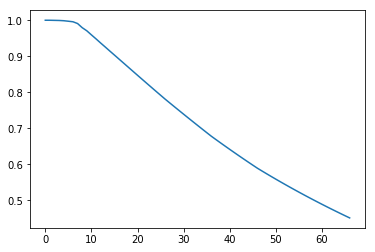

In [164]:
x = np.arange(67)
y = []
for i in range(len(bootstrapping_DF_swap_rate(DF_LIST, '6M'))):
    y.append(bootstrapping_DF_swap_rate(DF_LIST, '6M')[i][4])
plt.plot(x,y)

In [125]:
calc_daycount(DF_LIST[7][1],DF_LIST[7][2],360)

0.5

In [117]:
get_DF(mm_list, swap_rate_list, 1/2)

[['O/N', '2017/12/23', '2017/12/24', 0.014348, 0.99996014603284633],
 ['T/N', '2017/12/24', '2017/12/25', 0.014348, 0.99992029365403134],
 ['1W', '2017/12/25', '2018/1/1', 0.014876, 0.99963114479189386],
 ['2W', '2017/12/25', '2018/1/8', 0.015, 0.99933734686835807],
 ['1M', '2017/12/25', '2018/1/24', 0.01563, 0.99861959163592562],
 ['2M', '2017/12/25', '2018/2/23', 0.01616, 0.9972344089791807],
 ['3M', '2017/12/25', '2018/3/25', 0.01685, 0.99572579872689437],
 ['6M', '2017/12/25', '2018/6/23', 0.01833, 0.99083925191027356],
 ['1Y', '2017/12/25', '2018/12/20', 0.021, 0.97935386254067724],
 ['1.5Y', '2017/12/25', '2019/06/25', 0.019950000000000002, 0.0],
 ['2.0Y', '2017/12/25', '2019/12/25', '0.02086', 0.0],
 ['2.5Y', '2017/12/25', '2020/06/24', 0.021365000000000002, 0.0],
 ['3.0Y', '2017/12/25', '2020/12/24', '0.02187', 0.0],
 ['3.5Y', '2017/12/25', '2021/06/24', 0.022175, 0.0],
 ['4.0Y', '2017/12/25', '2021/12/24', '0.02248', 0.0],
 ['4.5Y', '2017/12/25', '2022/06/24', 0.022715, 0.0],


In [207]:
get_interpolated_swap_rate_list(swap_rate_list, 1/2)

[['1.0Y', '2017/12/25', '2018/12/25', '0.01904'],
 ['1.5Y', '2017/12/25', '2019/06/25', 0.019950000000000002],
 ['2.0Y', '2017/12/25', '2019/12/25', '0.02086'],
 ['2.5Y', '2017/12/25', '2020/06/24', 0.021365000000000002],
 ['3.0Y', '2017/12/25', '2020/12/24', '0.02187'],
 ['3.5Y', '2017/12/25', '2021/06/24', 0.022175],
 ['4.0Y', '2017/12/25', '2021/12/24', '0.02248'],
 ['4.5Y', '2017/12/25', '2022/06/24', 0.022715],
 ['5.0Y', '2017/12/25', '2022/12/24', '0.02295'],
 ['5.5Y', '2017/12/25', '2023/06/24', 0.02316],
 ['6.0Y', '2017/12/25', '2023/12/24', '0.02337'],
 ['6.5Y', '2017/12/25', '2024/06/23', 0.023565],
 ['7.0Y', '2017/12/25', '2024/12/23', '0.02376'],
 ['7.5Y', '2017/12/25', '2025/06/23', 0.023934999999999998],
 ['8.0Y', '2017/12/25', '2025/12/23', '0.02411'],
 ['8.5Y', '2017/12/25', '2026/06/23', 0.024274999999999998],
 ['9.0Y', '2017/12/25', '2026/12/23', '0.02444'],
 ['9.5Y', '2017/12/25', '2027/06/23', 0.024595],
 ['10.0Y', '2017/12/25', '2027/12/23', '0.02475'],
 ['10.5Y', 

In [250]:
swap_rate_list

[['1.0Y', '2017/12/25', '2018/12/25', '0.01904'],
 ['2.0Y', '2017/12/25', '2019/12/25', '0.02086'],
 ['3.0Y', '2017/12/25', '2020/12/24', '0.02187'],
 ['4.0Y', '2017/12/25', '2021/12/24', '0.02248'],
 ['5.0Y', '2017/12/25', '2022/12/24', '0.02295'],
 ['6.0Y', '2017/12/25', '2023/12/24', '0.02337'],
 ['7.0Y', '2017/12/25', '2024/12/23', '0.02376'],
 ['8.0Y', '2017/12/25', '2025/12/23', '0.02411'],
 ['9.0Y', '2017/12/25', '2026/12/23', '0.02444'],
 ['10.0Y', '2017/12/25', '2027/12/23', '0.02475'],
 ['15.0Y', '2017/12/25', '2032/12/21', '0.02582'],
 ['20.0Y', '2017/12/25', '2037/12/20', '0.02632'],
 ['30.0Y', '2017/12/25', '2047/12/18', '0.02646']]

In [195]:
a = [[1,2], [3,4]]
for i in range(2):
    a[i].append(0)
a

[[1, 2, 0], [3, 4, 0]]

In [60]:
import datetime
now = datetime.datetime.today()
d = now + datetime.timedelta(days=10)
d.strftime('%Y/%m/%d')

'2018/01/30'

In [62]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10])
y = np.array([20,20,15,14,1,4,2,6,1,1,1])
f = interp1d(x,y)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0]
[0.01904, 0.02086, 0.02187, 0.02248, 0.02295, 0.02337, 0.02376, 0.02411, 0.02444, 0.02475, 0.02582, 0.02632, 0.02646]


array(0.019950000000000002)

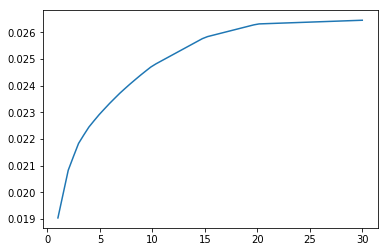

In [63]:
from scipy.interpolate import interp1d
x = []
y = []
for i in range(len(swap_rate_list)):
    x.append(float(swap_rate_list[i][0][0:len(swap_rate_list[i][0])-1]))
    y.append(float(swap_rate_list[i][3]))
print(x)
print(y)
f = interp1d(x,y)
xnew = np.linspace(1, 30, num=60, endpoint=True)
plt.plot(xnew, f(xnew), '-')
f(1.5)

### エラーメッセージ

---
TypeError                                 Traceback (most recent call last)
<ipython-input-29-8d376080b34d> in <module>()
     33     return daycount
     34 
---> 35 get_DF(mm_list)

<ipython-input-29-8d376080b34d> in get_DF(money_market_list)
     24     convention = 360.0
     25     day_count_fraction[0] = calc_daycount(money_market_list[0][1], money_market_list[0][2], convention)
---> 26     discount_factor[0][1] = 1.0 / (1.0 + day_count_fraction[0] * money_market_list[0][3])
     27     return discount_factor
     28 

TypeError: 'numpy.float64' object cannot be interpreted as an integer

---
### 解決策
- 数値と文字列が混ざっているのでどちらかに統一すべし